<a href="https://colab.research.google.com/github/yutongwu10/ece6143-project/blob/main/Jet_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
%pip uninstall -y pyjet numpy
%pip install "numpy<2"
%pip install --no-cache-dir pyjet

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 45.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26

In [ ]:
%pip install -U pip
%pip install pyjet keras tables numpy pandas matplotlib scikit-learn seaborn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from pyjet import cluster, DTYPE_EP
import keras
from keras import utils, layers, models, optimizers, callbacks
from keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
import seaborn as sns
import tensorflow as tf

np.random.seed(42)

## Dataset

In [ ]:
!wget "https://zenodo.org/records/2603256/files/val.h5?download=1" -O val.h5

In [ ]:
data = pd.read_hdf("val.h5", key="table")

In [ ]:
n_events = 10000

In [ ]:
sig_progress = utils.Progbar(n_events)
sig_fatjets = []
for _, event in data[data['is_signal_new'] == 1].iloc[:n_events].iterrows():
    particles = np.zeros(200, dtype=DTYPE_EP)
    for i in range(200):
        particles[i] = (event[f"E_{i}"], event[f"PX_{i}"], event[f"PY_{i}"], event[f"PZ_{i}"])
    fatjets = cluster(particles, R=1.0, p=-1, ep=True).inclusive_jets(10)
    if len(fatjets) > 0:
        sig_fatjets.append(fatjets[0])
    sig_progress.add(1)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step


In [ ]:
bkg_progress = utils.Progbar(n_events)
bkg_fatjets = []
for _, event in data[data['is_signal_new'] == 0].iloc[:n_events].iterrows():
    particles = np.zeros(200, dtype=DTYPE_EP)
    for i in range(200):
        particles[i] = (event[f"E_{i}"], event[f"PX_{i}"], event[f"PY_{i}"], event[f"PZ_{i}"])
    fatjets = cluster(particles, R=1.0, p=-1, ep=True).inclusive_jets(10)
    if len(fatjets) > 0:
        bkg_fatjets.append(fatjets[0])
    bkg_progress.add(1)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


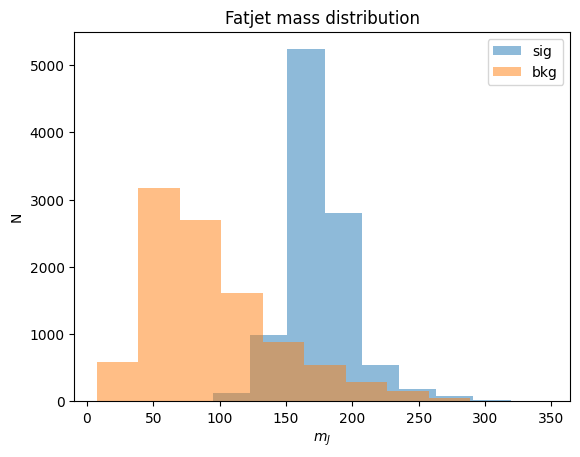

In [ ]:
plt.hist([jet.mass for jet in sig_fatjets], alpha=0.5, label="sig")
plt.hist([jet.mass for jet in bkg_fatjets], alpha=0.5, label="bkg")
plt.xlabel("$m_{J}$")
plt.ylabel("N")
plt.title("Fatjet mass distribution")
plt.legend()
plt.show()

In [ ]:
sig_progress = utils.Progbar(len(sig_fatjets))
sig_jet_images = []
for fatjet in sig_fatjets:
    constituents = fatjet.constituents_array()
    subjets = cluster(fatjet, algo="kt", R=0.3).inclusive_jets()
    if len(subjets) < 1:
        sig_progress.add(1)
        continue
    cst_pt = constituents["pT"]
    cst_eta = constituents["eta"]
    cst_phi = constituents["phi"]
    for i in range(len(cst_pt)):
        cst_eta[i] -= subjets[0].eta
        cst_phi[i] -= subjets[0].phi
    hist, _, _ = np.histogram2d(cst_eta, cst_phi, weights=cst_pt, bins=33, range=[(-1.6, 1.6), (-1.6, 1.6)])
    sig_jet_images.append(hist)
    sig_progress.add(1)
sig_jet_images = np.array(sig_jet_images)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1s 78us/step


In [ ]:
bkg_progress = utils.Progbar(len(bkg_fatjets))
bkg_jet_images = []
for fatjet in bkg_fatjets:
    constituents = fatjet.constituents_array()
    subjets = cluster(fatjet, algo="kt", R=0.3).inclusive_jets()
    if len(subjets) < 1:
        bkg_progress.add(1)
        continue
    cst_pt = constituents["pT"]
    cst_eta = constituents["eta"]
    cst_phi = constituents["phi"]
    for i in range(len(cst_pt)):
        cst_eta[i] -= subjets[0].eta
        cst_phi[i] -= subjets[0].phi
    hist, _, _ = np.histogram2d(cst_eta, cst_phi, weights=cst_pt, bins=33, range=[(-1.6, 1.6), (-1.6, 1.6)])
    bkg_jet_images.append(hist)
    bkg_progress.add(1)
bkg_jet_images = np.array(bkg_jet_images)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1s 71us/step


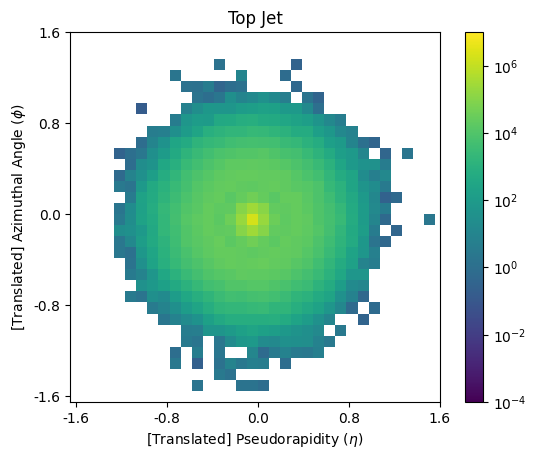

In [ ]:
plt.imshow(sig_jet_images.sum(0).T, origin="lower", norm=colors.LogNorm(vmin=1e-4, vmax=1e7))
plt.xticks(np.linspace(0, 33, 5), np.linspace(-1.6, 1.6, 5).round(2))
plt.yticks(np.linspace(0, 33, 5), np.linspace(-1.6, 1.6, 5).round(2))
plt.title("Top Jet")
plt.xlabel(r'[Translated] Pseudorapidity ($\eta$)')
plt.ylabel(r'[Translated] Azimuthal Angle ($\phi$)')
plt.colorbar()
plt.show()

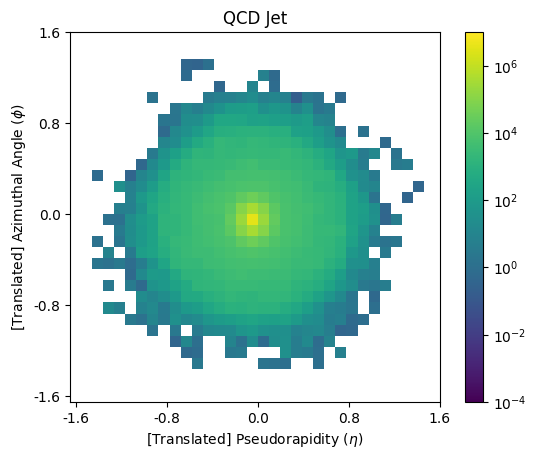

In [ ]:
plt.imshow(bkg_jet_images.sum(0).T, origin="lower", norm=colors.LogNorm(vmin=1e-4, vmax=1e7))
plt.xticks(np.linspace(0, 33, 5), np.linspace(-1.6, 1.6, 5).round(2))
plt.yticks(np.linspace(0, 33, 5), np.linspace(-1.6, 1.6, 5).round(2))
plt.title("QCD Jet")
plt.xlabel(r'[Translated] Pseudorapidity ($\eta$)')
plt.ylabel(r'[Translated] Azimuthal Angle ($\phi$)')
plt.colorbar()
plt.show()

In [ ]:
sig_jet_images = np.expand_dims(sig_jet_images, axis=-1)
bkg_jet_images = np.expand_dims(bkg_jet_images, axis=-1)

x = np.concatenate([sig_jet_images, bkg_jet_images], axis=0)
y = np.concatenate([np.ones(len(sig_jet_images)), np.zeros(len(bkg_jet_images))])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train = utils.to_categorical(y_train, num_classes=2)
y_test = utils.to_categorical(y_test, num_classes=2)

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (16000, 33, 33, 1)
x_test shape: (4000, 33, 33, 1)
y_train shape: (16000, 2)
y_test shape: (4000, 2)


# Model 1: LogisticRegression

# Model 2: SVM

In [ ]:
y_train_lr = np.argmax(y_train, axis=1)
y_test_lr  = np.argmax(y_test, axis=1)

x_train_lr = x_train.reshape(x_train.shape[0], -1)
x_test_lr  = x_test.reshape(x_test.shape[0], -1)

print("SVM input shape:", x_train_lr.shape)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        random_state=42
    ))
])

# Training

In [ ]:
print("="*50)
print("Training: SVM (RBF Kernel)")
print("="*50)

svm_model.fit(x_train_lr, y_train_lr)

print("Training finished.")

## Model 3: CNN

In [ ]:
inputs = layers.Input(shape=(33, 33, 1))
x_cnn = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
x_cnn = layers.MaxPooling2D(2)(x_cnn)
x_cnn = layers.Conv2D(64, 3, padding="same", activation="relu")(x_cnn)
x_cnn = layers.MaxPooling2D(2)(x_cnn)
x_cnn = layers.Conv2D(128, 3, padding="same", activation="relu")(x_cnn)
x_cnn = layers.MaxPooling2D(2)(x_cnn)
x_cnn = layers.Flatten()(x_cnn)
x_cnn = layers.Dense(64, activation="relu")(x_cnn)
outputs_cnn = layers.Dense(2, activation="softmax")(x_cnn)

model = models.Model(inputs, outputs_cnn, name="CNN")
model.summary()

2025-12-14 18:26:09.665491: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-14 18:26:09.665638: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-12-14 18:26:09.665648: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-12-14 18:26:09.665676: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-14 18:26:09.665695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 33, 33, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 33, 33, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,938 (874.76 KB)

 Trainable params: 223,938 (874.76 KB)

 Non-trainable params: 0 (0.00 B)

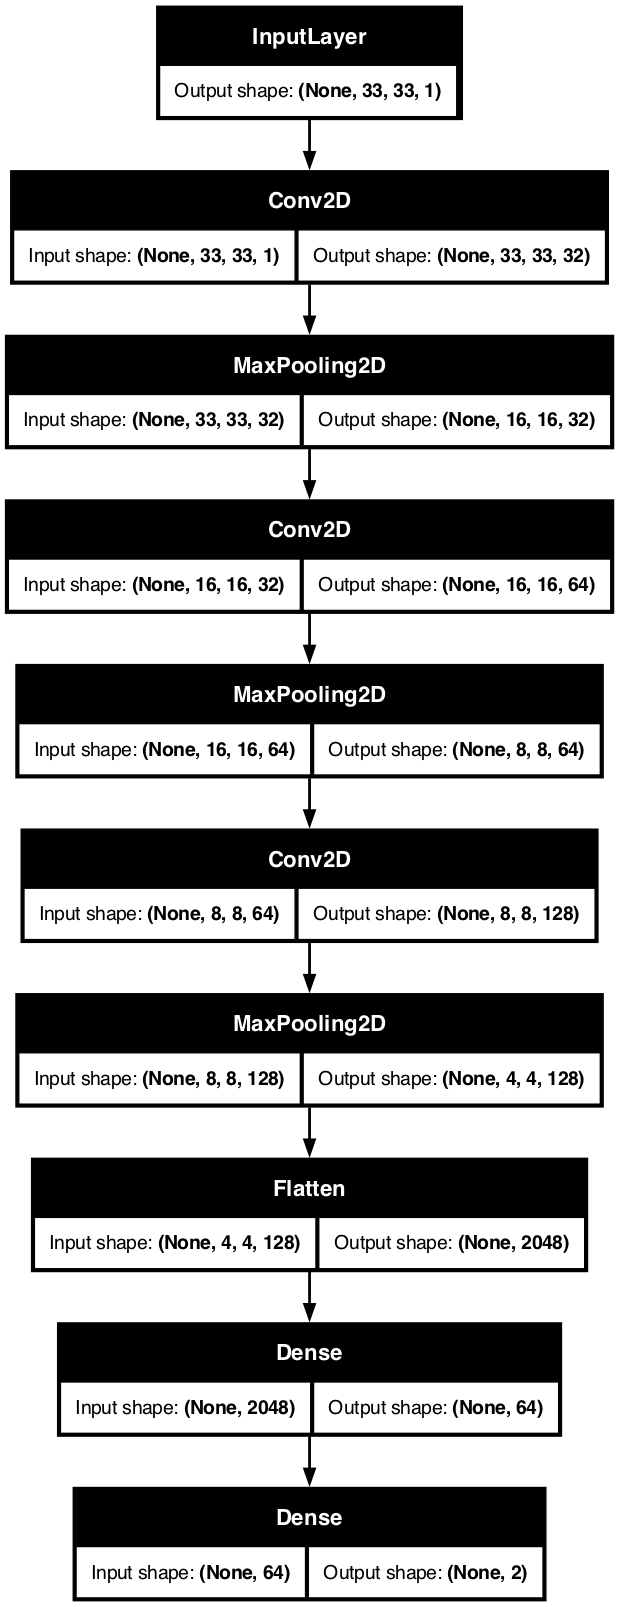

In [ ]:
utils.plot_model(model, show_shapes=True, dpi=100)

## Training

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history_cnn = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10


2025-12-14 18:27:02.700283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8363 - loss: 0.5169 - val_accuracy: 0.8720 - val_loss: 0.3180
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8602 - loss: 0.3346 - val_accuracy: 0.8805 - val_loss: 0.2840
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8696 - loss: 0.3093 - val_accuracy: 0.8890 - val_loss: 0.2720
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8798 - loss: 0.2870 - val_accuracy: 0.8885 - val_loss: 0.2709
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8818 - loss: 0.2836 - val_accuracy: 0.8815 - val_loss: 0.2850
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8817 - loss: 0.2807 - val_accuracy: 0.8982 - val_loss: 0.2490
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8898 - loss: 0.2679 - val_accuracy: 0.8953 - val_loss: 0.2542
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8866 - loss: 0.2721 - val_accuracy: 0.847


# Model 4: ResNet50 Fine-tuning






In [ ]:
def preprocess_for_resnet(X):
    """(N, 33, 33, 1) → (N, 75, 75, 3)"""
    N = X.shape[0]
    X_out = np.zeros((N, 75, 75, 3))
    for i in range(N):
        img = X[i, :, :, 0]
        img = np.log1p(img)
        img_min, img_max = img.min(), img.max()
        if img_max > img_min:
            img = (img - img_min) / (img_max - img_min) * 255

        img_resized = tf.image.resize(img[:, :, np.newaxis], (75, 75)).numpy()
        X_out[i] = np.concatenate([img_resized, img_resized, img_resized], axis=-1)
    return X_out

print("Preparing ResNet50 data...")
x_train_resnet = preprocess_for_resnet(x_train)
x_test_resnet = preprocess_for_resnet(x_test)
print(f"x_train_resnet shape: {x_train_resnet.shape}")
print(f"x_test_resnet shape: {x_test_resnet.shape}")


# Build ResNet50 fine-tuning model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
base_model.trainable = False  # Freeze pre-trained layers

inputs_resnet = layers.Input(shape=(75, 75, 3))
x_res = base_model(inputs_resnet, training=False)
x_res = layers.GlobalAveragePooling2D()(x_res)
x_res = layers.Dense(256, activation='relu')(x_res)
x_res = layers.Dropout(0.5)(x_res)
outputs_resnet = layers.Dense(2, activation='softmax')(x_res)

model_resnet = models.Model(inputs_resnet, outputs_resnet, name="ResNet50_Finetune")
model_resnet.summary()


# Phase 1: Train classification head only
print("="*50)
print("ResNet50 Phase 1: Train classification head")
print("="*50)
model_resnet.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
history_resnet1 = model_resnet.fit(x_train_resnet, y_train, batch_size=32, epochs=10, validation_data=(x_test_resnet, y_test))


# Phase 2: Unfreeze top layers for fine-tuning
print("="*50)
print("ResNet50 Phase 2: Fine-tune top layers")
print("="*50)
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False



Preparing ResNet50 data...
x_train_resnet shape: (16000, 75, 75, 3)
x_test_resnet shape: (4000, 75, 75, 3)


Model: "ResNet50_Finetune"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

ResNet50 Phase 1: Train classification head
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 59ms/step - accuracy: 0.7722 - loss: 0.6185 - val_accuracy: 0.8515 - val_loss: 0.3703
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.8238 - loss: 0.4143 - val_accuracy: 0.8608 - val_loss: 0.3423
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.8336 - loss: 0.3871 - val_accuracy: 0.8597 - val_loss: 0.3363
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.8396 - loss: 0.3829 - val_accuracy: 0.8612 - val_loss: 0.3312
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.8371 - loss: 0.3868 - val_accuracy: 0.8658 - val_loss: 0.3322
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.8428 - loss: 0.3744 - val_accuracy: 0.8597 - val_loss: 0.3501
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - accuracy: 0.8440 - loss: 0.3723 - val_accuracy: 0.8662 - val_loss: 0.3273
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 85

## Training

In [ ]:
model_resnet.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])
history_resnet2 = model_resnet.fit(x_train_resnet, y_train, batch_size=32, epochs=10, validation_data=(x_test_resnet, y_test))


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 155ms/step - accuracy: 0.7716 - loss: 0.7791 - val_accuracy: 0.8330 - val_loss: 0.4756
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - accuracy: 0.8073 - loss: 0.6198 - val_accuracy: 0.8455 - val_loss: 0.4340
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 169ms/step - accuracy: 0.8211 - loss: 0.5527 - val_accuracy: 0.8535 - val_loss: 0.4178
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 159ms/step - accuracy: 0.8368 - loss: 0.5291 - val_accuracy: 0.8612 - val_loss: 0.4787
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 161ms/step - accuracy: 0.8425 - loss: 0.4992 - val_accuracy: 0.8600 - val_loss: 0.4358
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 161ms/step - accuracy: 0.8463 - loss: 0.4670 - val_accuracy: 0.8450 - val_loss: 0.4568
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 160ms/step - accuracy: 0.8579 - loss: 0.4155 - val_accuracy: 0.8508 - val_loss: 0.4471
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 167ms/step - accuracy: 0.8640 - loss: 0

## Model 5: Optimised Physics MLP

In [ ]:
# Feature Extraction Function (4 features)
from sklearn.discriminant_analysis import StandardScaler


def extract_final_features(fatjets):
    """
    Extracts 4 features: Mass, pT, Subjet pT Ratio 1 (pT2/pT1), and Subjet pT Ratio 2 (pT3/pT2).
    """
    features = []

    for jet in fatjets:
        mass = jet.mass
        pt = jet.pt
        subjets = cluster(jet, algo="kt", R=0.3).inclusive_jets()

        subjet_pT21_ratio = 0.0
        subjet_pT32_ratio = 0.0

        if len(subjets) >= 2:
            pT1 = subjets[0].pt
            pT2 = subjets[1].pt
            subjet_pT21_ratio = pT2 / pT1

            if len(subjets) >= 3:
                pT3 = subjets[2].pt
                if pT2 > 0:
                    subjet_pT32_ratio = pT3 / pT2

        features.append([mass, pt, subjet_pT21_ratio, subjet_pT32_ratio])

    return np.array(features)

# --- Feature Extraction and Data Split ---
sig_features = extract_final_features(sig_fatjets)
bkg_features = extract_final_features(bkg_fatjets)

X_features = np.concatenate([sig_features, bkg_features], axis=0)
Y_labels = np.concatenate([np.ones(len(sig_features)), np.zeros(len(bkg_features))])

X_train_phys, X_test_phys, Y_train_phys, Y_test_phys = train_test_split(
    X_features, Y_labels, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_phys_scaled = scaler.fit_transform(X_train_phys)
X_test_phys_scaled = scaler.transform(X_test_phys)

Y_train_phys = utils.to_categorical(Y_train_phys, num_classes=2)
Y_test_phys = utils.to_categorical(Y_test_phys, num_classes=2)

print(f"X_train_phys_scaled shape: {X_train_phys_scaled.shape}")

X_train_phys_scaled shape: (16000, 4)


In [ ]:

input_dim = X_train_phys_scaled.shape[1]

inputs_mlp = layers.Input(shape=(input_dim,))

# Hidden Layer 1 (Increased units)
x_mlp = layers.Dense(128, activation='relu')(inputs_mlp)
x_mlp = layers.Dropout(0.2)(x_mlp)

# Hidden Layer 2
x_mlp = layers.Dense(64, activation='relu')(x_mlp)
x_mlp = layers.Dropout(0.2)(x_mlp)

# Hidden Layer 3
x_mlp = layers.Dense(32, activation='relu')(x_mlp)

# Output Layer
outputs_mlp = layers.Dense(2, activation='softmax')(x_mlp)

model_mlp_final = models.Model(inputs_mlp, outputs_mlp, name="Optimised_Physics_MLP")
model_mlp_final.summary()

Model: "Optimised_Physics_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,042 (43.13 KB)

 Trainable params: 11,042 (43.13 KB)

 Non-trainable params: 0 (0.00 B)

## Trainning

In [ ]:

print("\n" + "="*50)
print("TRAINING Optimised Physics MLP")
print("="*50)

# Compile with low learning rate
model_mlp_final.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Early Stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history_mlp_final = model_mlp_final.fit(
    X_train_phys_scaled, Y_train_phys,
    batch_size=32,
    epochs=100,
    validation_data=(X_test_phys_scaled, Y_test_phys),
    callbacks=[early_stopping],
    verbose=1
)


TRAINING Optimised Physics MLP
Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7511 - loss: 0.5312 - val_accuracy: 0.8668 - val_loss: 0.4056
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8545 - loss: 0.4066 - val_accuracy: 0.8823 - val_loss: 0.3532
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8681 - loss: 0.3767 - val_accuracy: 0.8817 - val_loss: 0.3379
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8681 - loss: 0.3670 - val_accuracy: 0.8832 - val_loss: 0.3323
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8699 - loss: 0.3646 - val_accuracy: 0.8827 - val_loss: 0.3300
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8708 - loss: 0.3622 - val_accuracy: 0.8820 - val_loss: 0.3291
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8745 - loss: 0.3615 - val_accuracy: 0.8827 - val_loss: 0.3286
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - ac

## Evaluation

In [ ]:
def evaluate_sklearn(model, X, y_onehot, name):
    y_pred_class = model.predict(X)
    y_score = model.predict_proba(X)[:, 1]
    y_true = np.argmax(y_onehot, axis=1)
    acc = accuracy_score(y_true, y_pred_class)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)

    return {
        'name': name,
        'acc': acc,
        'auc': auc_score,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred': y_pred_class,
        'y_true': y_true
    }

  res_svm = evaluate_sklearn(
    svm_model,
    x_test_lr,
    y_test,
    "SVM (RBF)"
)

In [ ]:
def evaluate(model, X, y, name):
    y_pred = model.predict(X, verbose=0)
    y_pred_class = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y, axis=1)
    acc = accuracy_score(y_true, y_pred_class)
    fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
    auc_score = auc(fpr, tpr)
    return {'name': name, 'acc': acc, 'auc': auc_score, 'fpr': fpr, 'tpr': tpr,
            'y_pred': y_pred_class, 'y_true': y_true}

res_cnn = evaluate(model, x_test, y_test, "CNN")
res_resnet = evaluate(model_resnet, x_test_resnet, y_test, "ResNet50")
res_mlp = evaluate(model_mlp_final, X_test_phys_scaled, Y_test_phys, "Physics MLP")
results = [res_svm, res_cnn, res_resnet, res_mlp]


print("\n" + "="*50)
print("Results Comparison")
print("="*50)
print(f"{'Model':<15} {'AUC':<10} {'Accuracy':<10}")
print("-"*50)
for r in results:
    print(f"{r['name']:<15} {r['auc']:<10.4f} {r['acc']*100:<10.2f}%")
print("="*50)




Results Comparison
Model           AUC        Accuracy  
--------------------------------------------------
CNN             0.9578     89.05     %
ResNet50        0.9270     85.55     %
Physics MLP     0.9258     88.28     %


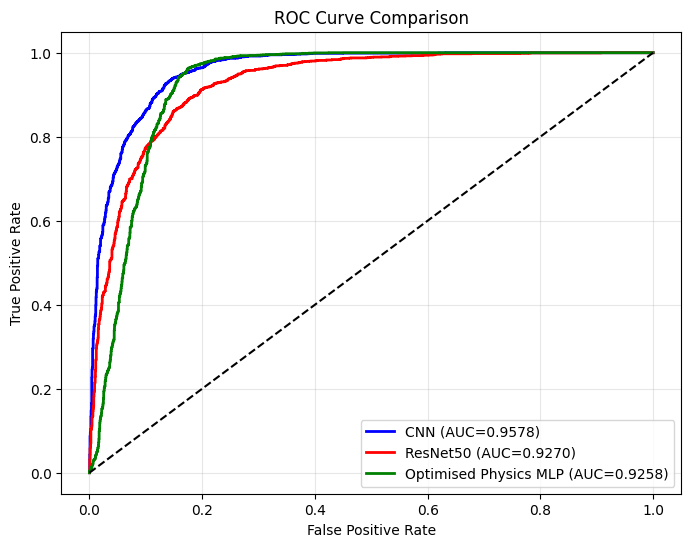

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(res_svm['fpr'], res_svm['tpr'], 'm--', lw=2,label=f"SVM (RBF) (AUC={res_svm['auc']:.4f})")
plt.plot(res_cnn['fpr'], res_cnn['tpr'], 'b-', lw=2, label=f"CNN (AUC={res_cnn['auc']:.4f})")
plt.plot(res_resnet['fpr'], res_resnet['tpr'], 'r-', lw=2, label=f"ResNet50 (AUC={res_resnet['auc']:.4f})")
plt.plot(res_mlp['fpr'], res_mlp['tpr'], 'g-', lw=2, label=f"Optimised Physics MLP (AUC={res_mlp['auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('roc_comparison.png', dpi=150)
plt.show()

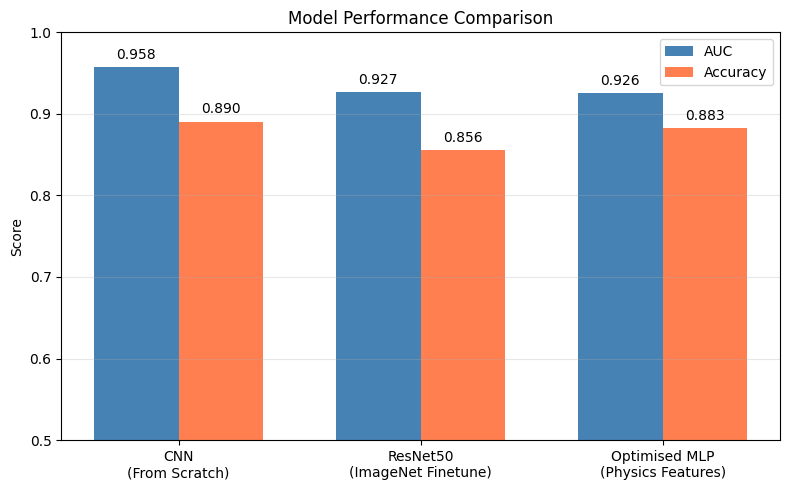

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
x_pos = np.arange(4)
width = 0.35

bars1 = ax.bar(x_pos - width/2, [res_svm['auc'], res_cnn['auc'], res_resnet['auc'],res_mlp['auc']], width, label='AUC', color='steelblue')
bars2 = ax.bar(x_pos + width/2, [res_svm['auc'], res_cnn['acc'], res_resnet['acc'],res_mlp['acc']], width, label='Accuracy', color='coral')

ax.set_xticks(x_pos)
ax.set_xticklabels(['SVM\n(RBF Kernel)','CNN\n(From Scratch)', 'ResNet50\n(ImageNet Finetune)','Optimised MLP\n(Physics Features)'])
ax.set_ylim([0.5, 1.0])
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', fontsize=10)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('comparison_bar.png', dpi=150)
plt.show()

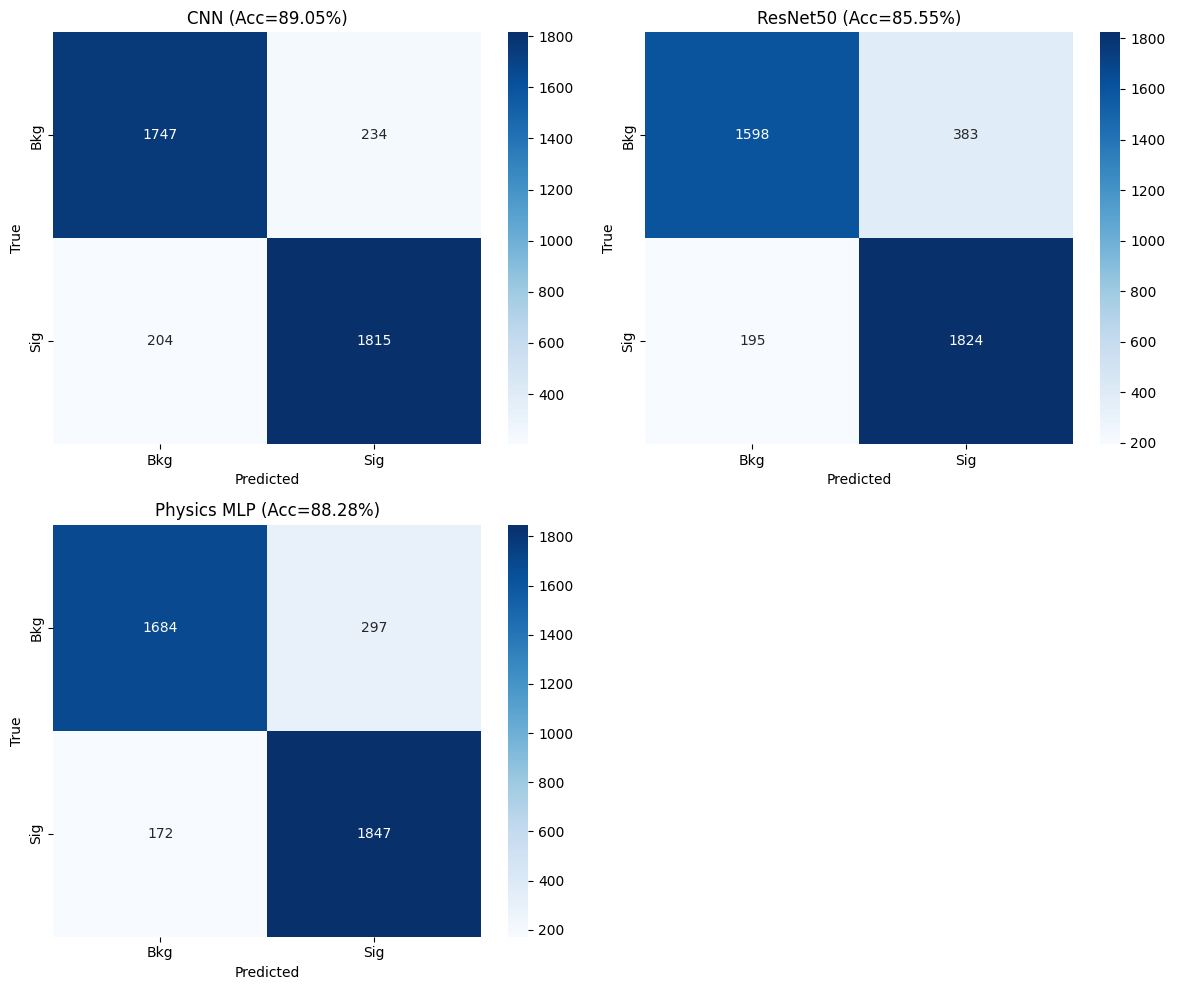

Done!


In [ ]:
import math

n = len(results)
ncols = min(2, n)
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
axes = np.array(axes).reshape(-1)

for ax, res in zip(axes, results):
    cm = confusion_matrix(res['y_true'], res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Bkg', 'Sig'], yticklabels=['Bkg', 'Sig'])
    ax.set_title(f"{res['name']} (Acc={res['acc']:.2%})")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

for i in range(len(results), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

print("Done!")